In [1]:
import pandas as pd
from recs_dev import df

                    song_name   mood  danceability  energy  key  loudness  \
0                Shape of You  Happy         0.825   0.652    1    -3.183   
1           Despacito (Remix)  Happy         0.653   0.816    2    -4.353   
2          That's What I Like  Happy         0.853   0.560    1    -4.961   
3    Something Just Like This  Happy         0.617   0.635   11    -6.769   
4                      Closer  Happy         0.711   0.753    4    -6.461   
..                        ...    ...           ...     ...  ...       ...   
147                    Malibu   Calm         0.831   0.719   10    -6.836   
148                      Down   Calm         0.962   0.619   10    -5.562   
149          Treat You Better   Calm         0.444   0.819   10    -4.078   
150                  Do Re Mi   Calm         0.745   0.593    8    -6.350   
151               The Fighter   Calm         0.681   0.845   11    -5.147   

     mode  speechiness  acousticness  instrumentalness  liveness  valence  

### Pandas Dataframe Agent

https://python.langchain.com/docs/integrations/toolkits/pandas

In [ ]:
print(df.shape)
df.head()

In [ ]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

In [ ]:
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    df,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
agent.run("What is the average 'danceability' for 'Happy'?")

In [ ]:
agent.run("Which audio feature is most significant to 'Happy'?") # appears to run inefficiently

In [ ]:
agent.run("Which columns are most significant to 'Calm'?")

### Feature Averages

In [2]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df['mood'] = df['mood']
average_moods = numeric_df.groupby('mood').mean()
average_moods.reset_index(inplace=True)
average_moods

,mood,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Calm,0.656645,0.617968,5.483871,-6.566935,0.612903,0.117171,0.192248,0.002959,0.131584,0.490419,117.556065,224035.032258,3.935484
1,Energetic,0.751902,0.649443,4.901639,-5.698049,0.573770,0.160310,0.132689,0.003270,0.151093,0.514098,129.139262,221331.065574,4.016393
2,Happy,0.689595,0.657048,4.976190,-5.753810,0.666667,0.117595,0.176064,0.000361,0.136352,0.577214,114.095524,217561.547619,4.023810
3,Sad,0.608056,0.574667,5.777778,-6.439667,0.500000,0.138333,0.230820,0.000005,0.148961,0.390556,115.086056,236491.944444,3.833333


### Correlation Analysis

Moods are categorical, so we'll convert them to binary variables for this analysis. 

We'll assign 1 to the mood of interest and 0 to the others.

In [ ]:
mood = "Calm"

df['is_calm'] = df['mood'].apply(lambda x: 1 if x == mood else 0)

# Calculate the correlation of 'is_calm' with each audio feature
correlations = df[['is_calm', 'danceability', 'energy', 'acousticness', 'instrumentalness', 'valence', 'tempo']].corr()

# Print the correlation of 'is_calm' with each audio feature
correlations['is_calm']

### Analysis of Variance (ANOVA)

Shows if the differences in means are statistically significant.

ANOVA assumes data is normally distributed & variances are equal across groups.

**Shapiro-Wilk Test**

If p-value > 0.05, we assume normality. This would need to be done for each mood.

In [ ]:
feature = "danceability"

In [ ]:
from scipy.stats import shapiro


for mood in (df["mood"]).unique():
    stat, p = shapiro(df[df['mood'] == mood][feature])
    print(f'Statistics=%.3f, p=%.3f' % (stat, p) ,mood)

**Levene's Test**

If p-value > 0.05, we assume equal variances.

In [ ]:
from scipy.stats import levene


# Test if variances are equal across groups
stat, p = levene(df[df['mood'] == 'Happy'][feature], 
                 df[df['mood'] == 'Sad'][feature], 
                 df[df['mood'] == 'Energetic'][feature], 
                 df[df['mood'] == 'Calm'][feature])
print('Statistics=%.3f, p=%.3f' % (stat, p))

**ANOVA Test**

In [ ]:
import scipy.stats as stats


# Let's say we want to test if the 'valence' is significantly different across moods
fvalue, pvalue = stats.f_oneway(df[df['mood'] == 'Happy'][feature], 
                                df[df['mood'] == 'Sad'][feature], 
                                df[df['mood'] == 'Energetic'][feature], 
                                df[df['mood'] == 'Calm'][feature])


print("F-value: ", fvalue)
print("P-value: ", pvalue)

The F-value is a measure of the ratio of between-group variance to within-group variance. A larger F-value suggests that there is more variation between the groups than within the groups, which could indicate a significant difference between the groups.

The p-value is the probability of obtaining the observed data (or data more extreme) if the null hypothesis is true. In this case, the null hypothesis is that there is no difference in 'feature' across the different moods. A p-value less than 0.05 is commonly interpreted as evidence to reject the null hypothesis in favor of the alternative hypothesis, which is that there is a difference in 'feature' across the moods.

### Graphs

Helpful for defining (arbitrary) min/max thresholds.

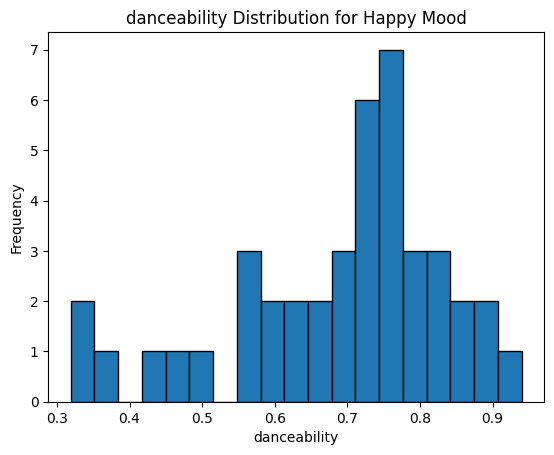

In [3]:
import matplotlib.pyplot as plt
import numpy as np


mood = "Happy"
feature = "danceability"

# Filter the dataframe to the right mood
happy_df = df[df["mood"] == mood]

# Calculate the range of values for feature
min_value = happy_df[feature].min()
max_value = happy_df[feature].max()
bin_range = np.linspace(min_value, max_value, num=20)

# Plot a histogram for the feature column in the mood
plt.hist(happy_df[feature], bins=bin_range, edgecolor='black')
plt.xlabel(feature)
plt.ylabel('Frequency')
plt.title(f'{feature} Distribution for {mood} Mood')
plt.show()

### Mood Creation

Let's keep it simple to start | 1-2 audio features

In [4]:
average_moods

,mood,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Calm,0.656645,0.617968,5.483871,-6.566935,0.612903,0.117171,0.192248,0.002959,0.131584,0.490419,117.556065,224035.032258,3.935484
1,Energetic,0.751902,0.649443,4.901639,-5.698049,0.573770,0.160310,0.132689,0.003270,0.151093,0.514098,129.139262,221331.065574,4.016393
2,Happy,0.689595,0.657048,4.976190,-5.753810,0.666667,0.117595,0.176064,0.000361,0.136352,0.577214,114.095524,217561.547619,4.023810
3,Sad,0.608056,0.574667,5.777778,-6.439667,0.500000,0.138333,0.230820,0.000005,0.148961,0.390556,115.086056,236491.944444,3.833333


In [ ]:
# version 2

MOOD_SETTINGS = {
    "happy": {"max_instrumentalness": 0.001, "min_valence": 0.6},
    "sad": {"max_danceability": 0.65, "max_valence": 0.4},
    "energetic": {"min_tempo": 130, "min_danceability": 0.75},
    "calm": {"max_energy": 0.65, "max_tempo": 130}
}

In [ ]:
# version 1

# MOOD_SETTINGS = {
#     "happy": {"max_instrumentalness": 0.001, "min_valence": 0.5},
#     "sad": {"max_danceability": 0.75, "max_valence": 0.5},
#     "energetic": {"min_tempo": 120, "min_danceability": 0.65},
#     "calm": {"max_energy": 0.75, "max_tempo": 140}
# }